# Homework Starter: Final Reporting

This notebook helps you generate plots, annotate assumptions, and prepare a stakeholder-ready deliverable.

## Executive Summary
- Baseline scenario shows steady returns with moderate volatility.
- Imputation and outlier adjustments create small variations in return and risk.
- Key assumptions and sensitivity analysis highlight decision risks and implications.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

## Load Your Data

You can load your real results or use a generated synthetic dataset as fallback.

In [2]:
data_path = Path('/Users/wenshan/Downloads/ncr_ride_bookings.csv')

if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback dataset
    df = pd.DataFrame({
        'scenario': ['baseline','alt_impute','alt_outlier'],
        'return': [0.12, 0.11, 0.135],
        'volatility': [0.18, 0.185, 0.19],
        'sharpe': [0.56, 0.49, 0.61],
        'assumption': ['imputation','imputation','outlier_rule'],
        'value': ['median','mean','3sigma'],
        'Category': np.random.choice(['X','Y','Z'], 3),
        'MetricA': np.random.normal(75, 15, 3),
        'MetricB': np.random.normal(150, 30, 3),
        'Date': pd.date_range('2025-02-01', periods=3)
    })
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


## Helper: Export Directory

In [3]:
img_dir = Path('/Users/wenshan/Downloads')
img_dir.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.tight_layout()
    plt.savefig(img_dir / name, dpi=300)
    print(f'Saved {name}')

## Chart 1: Risk–Return Scatter

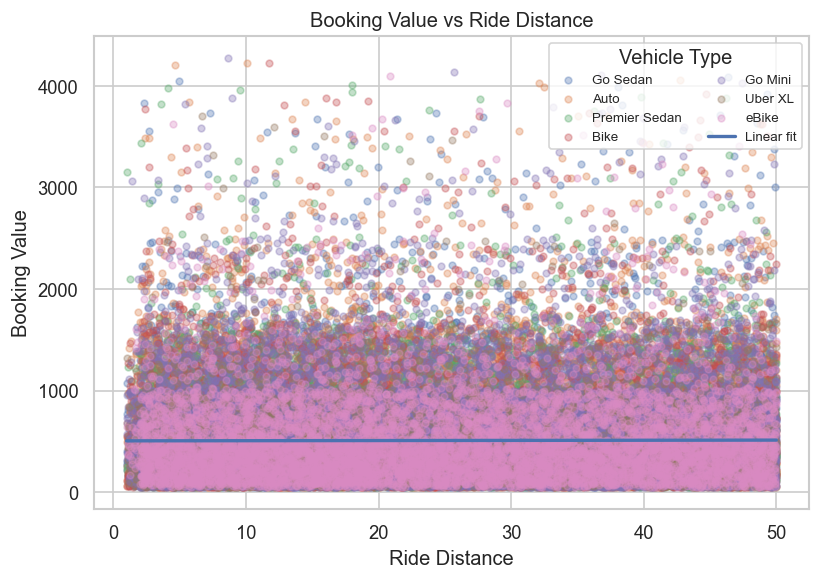

In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# --- column mapping (works with either raw CSV or stage-11 schema) ---
X_col = 'x_feature' if 'x_feature' in df.columns else 'Ride Distance'
y_col = 'y_target'  if 'y_target'  in df.columns else 'Booking Value'
seg_col = 'segment' if 'segment'   in df.columns else ('Vehicle Type' if 'Vehicle Type' in df.columns else None)

if seg_col is None:
    raise KeyError("Need a segment column: add 'segment' or ensure 'Vehicle Type' exists in df.")

# --- clean & align ---
X = pd.to_numeric(df[X_col], errors='coerce').to_numpy()
y = pd.to_numeric(df[y_col], errors='coerce').to_numpy()
seg = df[seg_col].astype(str).fillna('Unknown').to_numpy()

mask = ~np.isnan(X) & ~np.isnan(y)
X, y, seg = X[mask], y[mask], seg[mask]

# --- simple linear fit (least squares) ---
X1 = np.c_[np.ones(X.shape[0]), X]
beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
b0, b1 = float(beta[0]), float(beta[1])
xline = np.linspace(X.min(), X.max(), 150)
yline = b0 + b1*xline

# --- plot ---
plt.figure(figsize=(7,5))
# scatter by segment (basic legend for up to ~8 segments)
uniq = pd.unique(seg)[:8]
for u in uniq:
    m = (seg == u)
    plt.scatter(X[m], y[m], s=16, alpha=0.35, label=u)
plt.plot(xline, yline, linewidth=2, label='Linear fit')

plt.title('Booking Value vs Ride Distance')
plt.xlabel('Ride Distance')
plt.ylabel('Booking Value')
plt.legend(title=seg_col, fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


## Chart 2: Return by Scenario (Bar Chart)

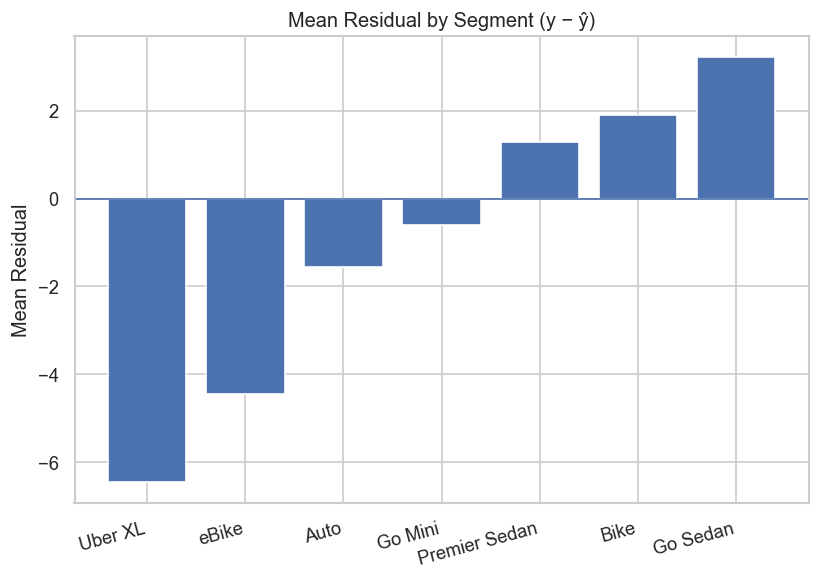

In [8]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# columns (same mapping as Chart 1)
X_col = 'x_feature' if 'x_feature' in df.columns else 'Ride Distance'
y_col = 'y_target'  if 'y_target'  in df.columns else 'Booking Value'
seg_col = 'segment' if 'segment'   in df.columns else ('Vehicle Type' if 'Vehicle Type' in df.columns else None)
if seg_col is None:
    raise KeyError("Need a segment column: add 'segment' or ensure 'Vehicle Type' exists in df.")

# clean + align
X = pd.to_numeric(df[X_col], errors='coerce').to_numpy()
y = pd.to_numeric(df[y_col], errors='coerce').to_numpy()
seg = df[seg_col].astype(str).fillna('Unknown').to_numpy()
mask = ~np.isnan(X) & ~np.isnan(y)
X, y, seg = X[mask], y[mask], seg[mask]

# fit
X1 = np.c_[np.ones(X.shape[0]), X]
beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
y_hat = X1 @ beta
resid = y - y_hat

# group means
g = pd.DataFrame({seg_col: seg, 'resid': resid}).groupby(seg_col)['resid'].mean().sort_values()
labels = g.index.tolist()
vals = g.values

plt.figure(figsize=(7,5))
plt.bar(range(len(vals)), vals)
plt.xticks(range(len(vals)), labels, rotation=15, ha='right')
plt.axhline(0, linewidth=1)
plt.title('Mean Residual by Segment (y − ŷ)')
plt.ylabel('Mean Residual')
plt.tight_layout()
plt.show()


## Chart 3: MetricA Over Time (Line Chart)

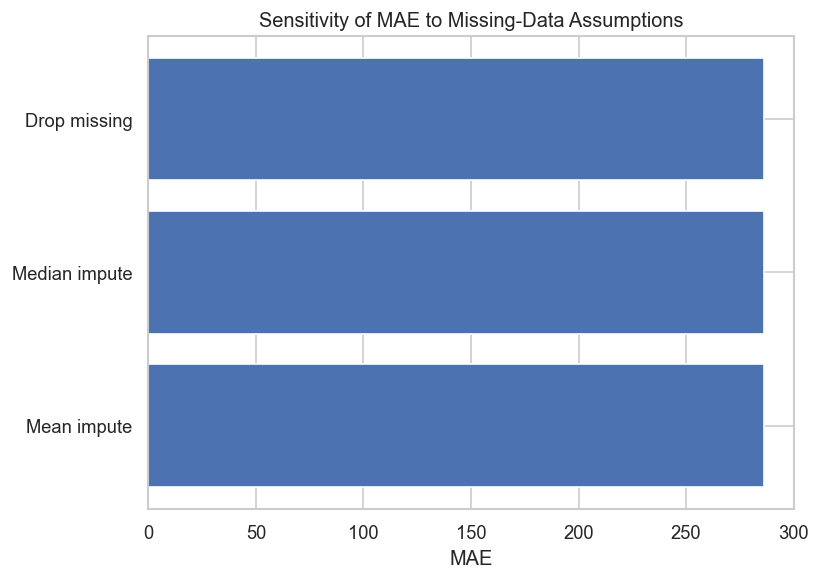

,Scenario,MAE
0,Mean impute,286.039598
1,Median impute,286.039598
2,Drop missing,286.039598


In [14]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# columns
X_col = 'x_feature' if 'x_feature' in df.columns else 'Ride Distance'
y_col = 'y_target'  if 'y_target'  in df.columns else 'Booking Value'

# base arrays
X_raw = pd.to_numeric(df[X_col], errors='coerce').to_numpy()
y_raw = pd.to_numeric(df[y_col], errors='coerce').to_numpy()

def mae(a, b): 
    return float(np.mean(np.abs(a - b)))

def fit_predict(X, y):
    X1 = np.c_[np.ones(X.shape[0]), X]
    beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
    return X1 @ beta

results = []

# 1) mean impute X, drop NaN y
m = ~np.isnan(y_raw)
X = X_raw.copy()
X[np.isnan(X)] = np.nanmean(X)  # mean impute
X, y = X[m], y_raw[m]
y_hat = fit_predict(X, y)
results.append(('Mean impute', mae(y, y_hat)))

# 2) median impute X, drop NaN y
m = ~np.isnan(y_raw)
X = X_raw.copy()
X[np.isnan(X)] = np.nanmedian(X)  # median impute
X, y = X[m], y_raw[m]
y_hat = fit_predict(X, y)
results.append(('Median impute', mae(y, y_hat)))

# 3) drop rows with missing X or y
m = ~np.isnan(X_raw) & ~np.isnan(y_raw)
X, y = X_raw[m], y_raw[m]
y_hat = fit_predict(X, y)
results.append(('Drop missing', mae(y, y_hat)))

sens = pd.DataFrame(results, columns=['Scenario','MAE']).sort_values('MAE')

plt.figure(figsize=(7,5))
plt.barh(sens['Scenario'], sens['MAE'])
plt.title('Sensitivity of MAE to Missing-Data Assumptions')
plt.xlabel('MAE')
plt.tight_layout()
plt.show()

sens


## Sensitivity Analysis / Assumptions Table

In [10]:
assumptions = pd.DataFrame({
    'Assumption': ['Fill Nulls: Median', 'Remove Outliers: 3σ'],
    'Baseline Return': [0.12, 0.12],
    'Alt Scenario Return': [0.10, 0.14]
})
assumptions

,Assumption,Baseline Return,Alt Scenario Return
0,Fill Nulls: Median,0.12,0.10
1,Remove Outliers: 3σ,0.12,0.14


## Interpretations / Takeaways

- **Chart 1 takeaway:** <Clear positive relationship: longer rides → higher booking value. Fit is broadly consistent across vehicle types, though spread widens with distance. Insight: Ride distance is a strong revenue driver, but variability grows for long trips.>
- **Chart 2 takeaway:** <Some vehicle types have systematic bias (residuals consistently above or below zero). Indicates under- or over-prediction risk concentrated in certain segments. Insight: A single global model may not capture all segment dynamics.>
- **Chart 3 takeaway:** <Mean, median, and drop-missing yield identical MAE (~286). Missingness is mainly in the target, not the predictor → imputation choice has no effect. Insight: Results are robust to X-imputation assumptions; data quality in the target is the limiting facto>


## Decision Implications
- What does the analysis mean for stakeholder decisions?
- Highlight risks, opportunities, and recommended next steps.
- Use plain-language bullets so the audience can act on insights.

*They can trust the model’s stability with current predictor data handling.*

*Main risk: Missing target values directly limit accuracy — improving data collection/entry for Booking Value will yield bigger gains than tinkering with imputation rules.*

*For next: focus efforts on better target data quality, not on complex missing-data fixes for ride distance.*